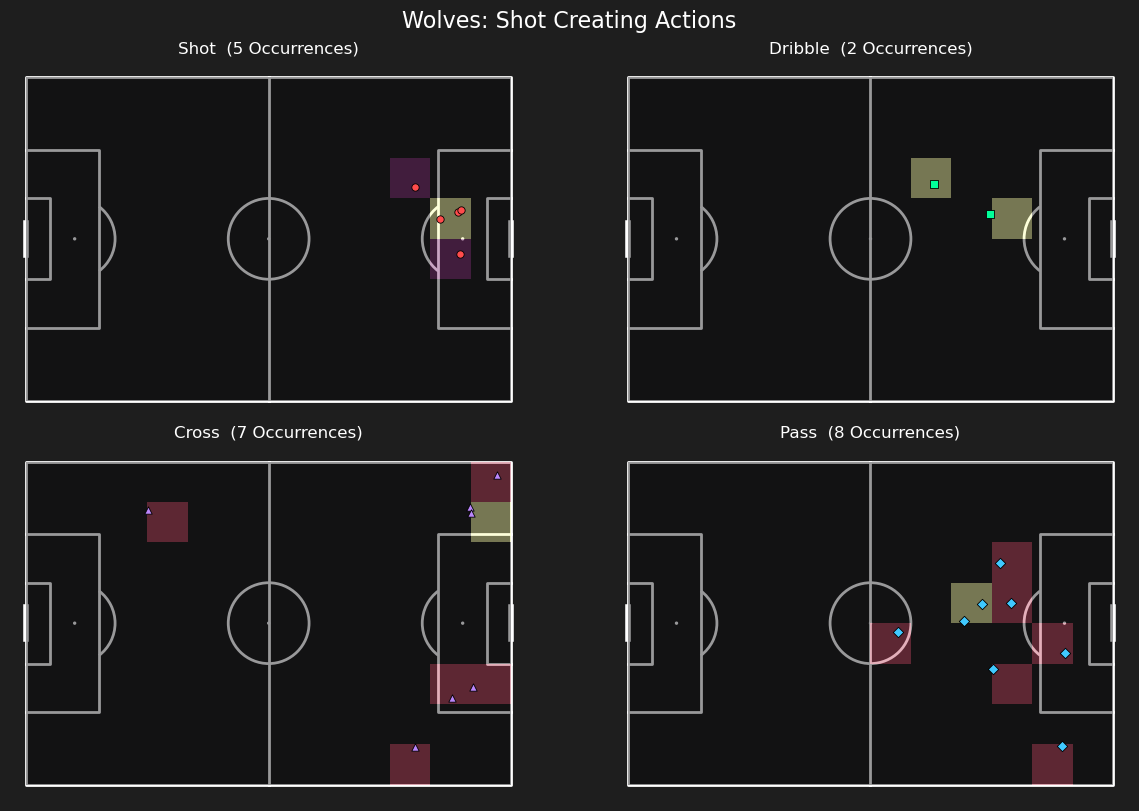

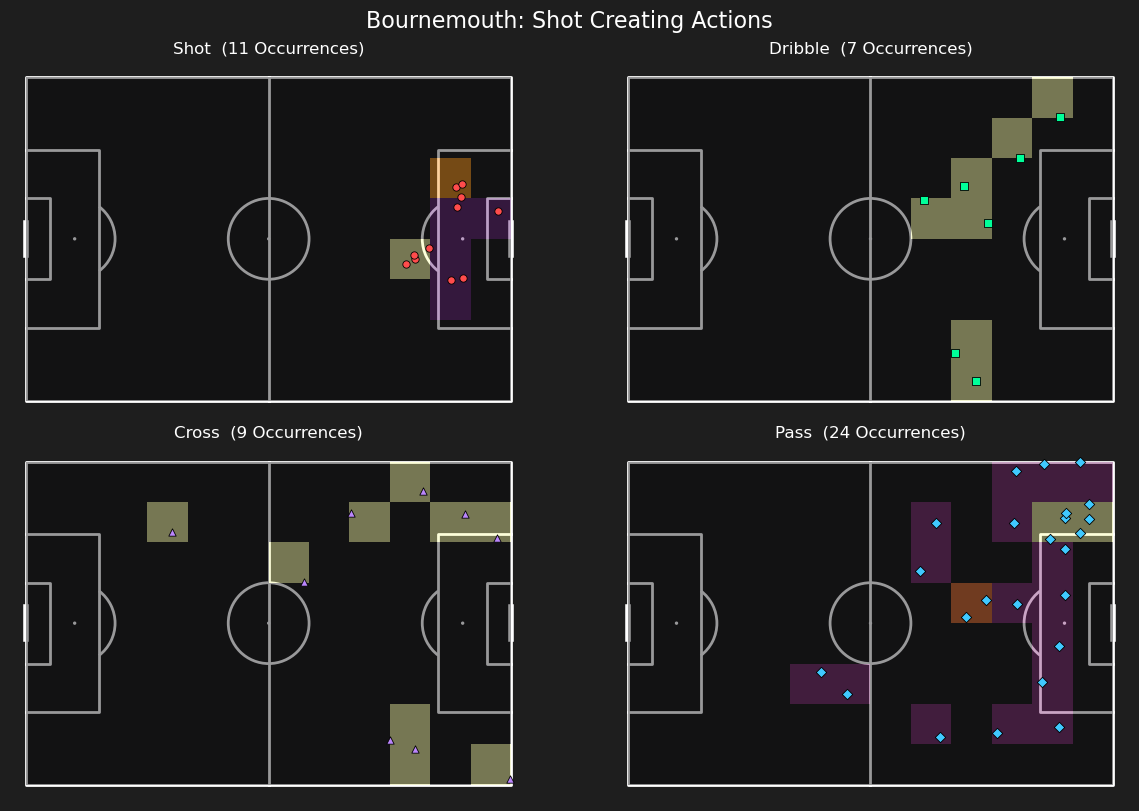

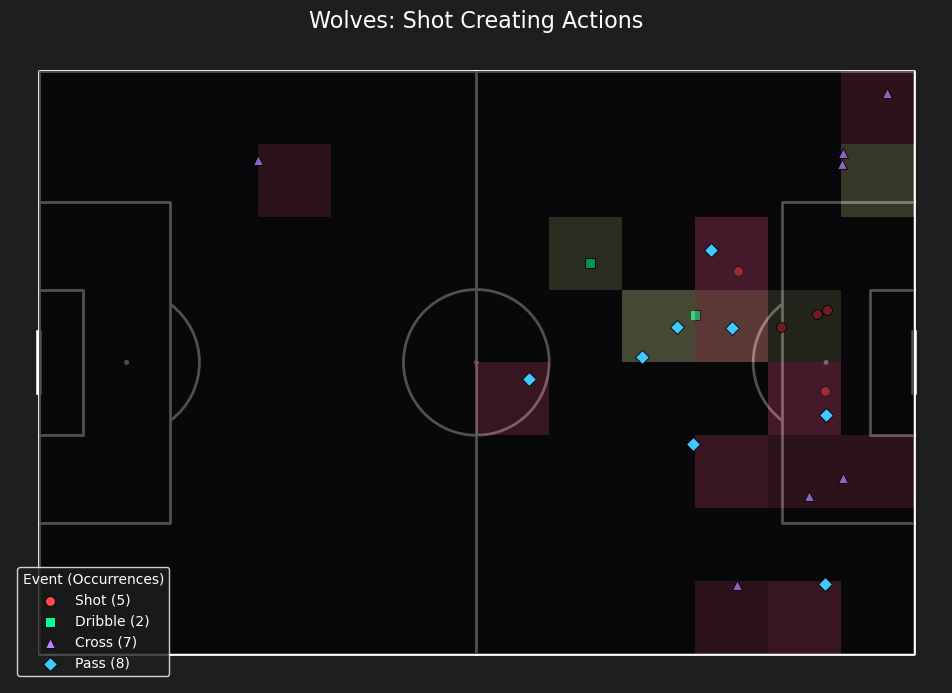

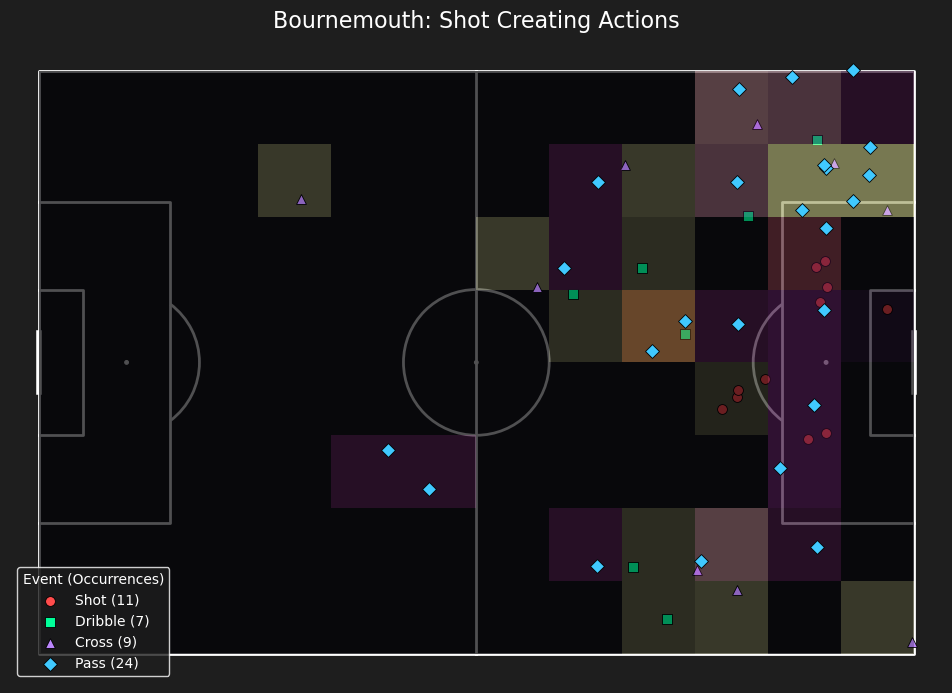

In [5]:
# !pip install mplsoccer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch

file_path = "8-23-2025.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

normalize = {
    "shot": "Shot", "shots": "Shot",
    "dribble": "Dribble", "dribbles": "Dribble",
    "cross": "Cross", "crosses": "Cross",
    "pass": "Pass", "passes": "Pass"
}
df["Event"] = (
    df["Event"].astype(str).str.strip().str.lower().map(normalize).fillna(df["Event"])
)

df["X_sb"] = (df["X"].astype(float) * 1.2).clip(0, 120)
df["Y_sb"] = (df["Y"].astype(float) * 0.8).clip(0, 80)

wolves_df = df[df["Team"].str.strip().str.lower() == "wolves"].copy()
bou_df   = df[df["Team"].str.strip().str.lower() != "wolves"].copy()

event_order = ["Shot", "Dribble", "Cross", "Pass"]
event_markers = {"Shot": "o", "Dribble": "s", "Cross": "^", "Pass": "D"}
event_colors = {
    "Shot": "#ff4c4c",
    "Dribble": "#00ff99",
    "Cross": "#bb86fc",
    "Pass": "#40c9ff",
}

def add_jitter(x, y, scale_x=0.3, scale_y=0.2, seed=42):
    rng = np.random.default_rng(seed)
    return x + rng.normal(0, scale_x, size=len(x)), y + rng.normal(0, scale_y, size=len(y))

def panel(ax, data, title):
    pitch = Pitch(pitch_type="statsbomb", pitch_color="#1e1e1e", line_color="white")
    pitch.draw(ax=ax)

    if not data.empty:
        bs = pitch.bin_statistic(
            data["X_sb"].values, data["Y_sb"].values,
            statistic='count', bins=(12, 8)
        )
        pitch.heatmap(bs, ax=ax, cmap="inferno", edgecolors=None, alpha=0.4)
        xj, yj = add_jitter(data["X_sb"].values, data["Y_sb"].values)
        pitch.scatter(
            xj, yj, ax=ax, s=28, marker=event_markers[title],
            c=event_colors[title], edgecolors="black", linewidths=0.6, zorder=3
        )

    ax.set_title(f"{title}  ({len(data)} Occurrences)", fontsize=12, pad=6, color="white")

def plot_team_grid(team_name, team_df):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True, facecolor="#1e1e1e")
    axes = axes.ravel()

    for i, evt in enumerate(event_order):
        sub = team_df[team_df["Event"] == evt]
        panel(axes[i], sub, evt)

    fig.suptitle(f"{team_name}: Shot Creating Actions", fontsize=16, color="white")
    plt.show()

def plot_combined(team_name, team_df):
    pitch = Pitch(pitch_type="statsbomb", pitch_color="#1e1e1e", line_color="white")
    fig, ax = pitch.draw(figsize=(10, 7))
    fig.set_facecolor("#1e1e1e")

    handles = []
    for evt in event_order:
        sub = team_df[team_df["Event"] == evt]
        if sub.empty:
            continue
        bs = pitch.bin_statistic(sub["X_sb"].values, sub["Y_sb"].values, statistic='count', bins=(12, 8))
        pitch.heatmap(bs, ax=ax, cmap="inferno", edgecolors=None, alpha=0.25)
        xj, yj = add_jitter(sub["X_sb"].values, sub["Y_sb"].values, scale_x=0.25, scale_y=0.18, seed=7)
        sc = pitch.scatter(
            xj, yj, ax=ax, s=50, marker=event_markers[evt],
            c=event_colors[evt], edgecolors="black", linewidths=0.6,
            label=f"{evt} ({len(sub)})"
        )
        handles.append(sc)

    ax.set_title(f"{team_name}: Shot Creating Actions", fontsize=16, pad=10, color="white")
    if handles:
        leg = ax.legend(loc="lower left", frameon=True, title="Event (Occurrences)",
                        labelcolor="white", facecolor="#1e1e1e", edgecolor="white")
        leg.get_title().set_color("white")
    plt.show()

plot_team_grid("Wolves", wolves_df)
plot_team_grid("Bournemouth", bou_df)

plot_combined("Wolves", wolves_df)
plot_combined("Bournemouth", bou_df)


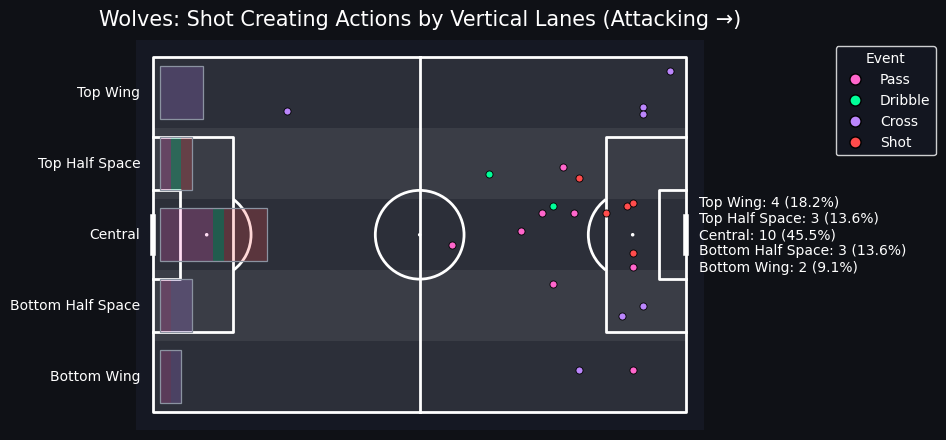

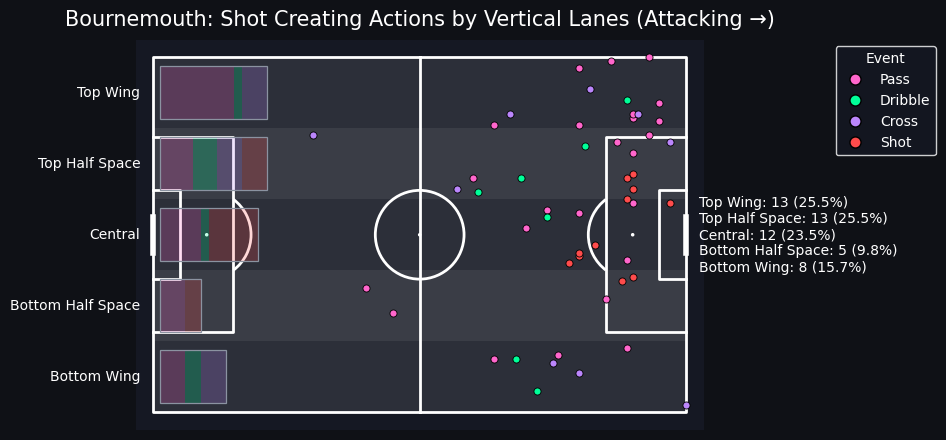

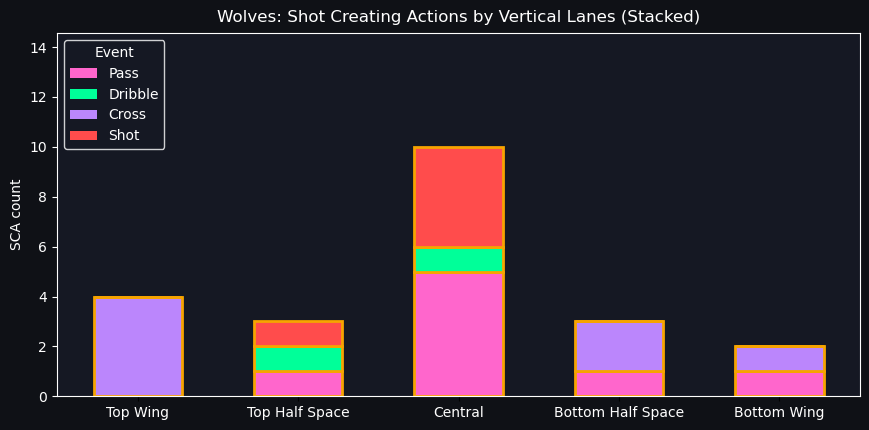

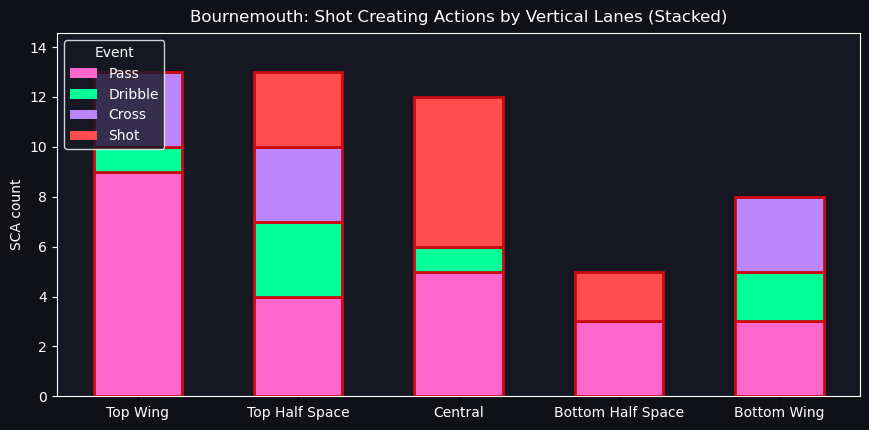

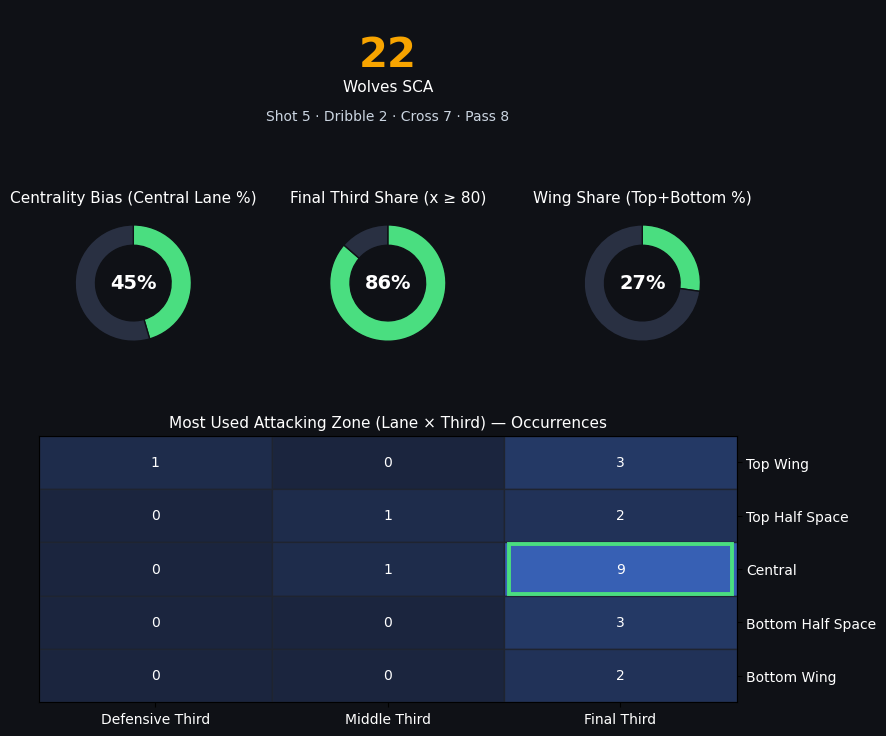

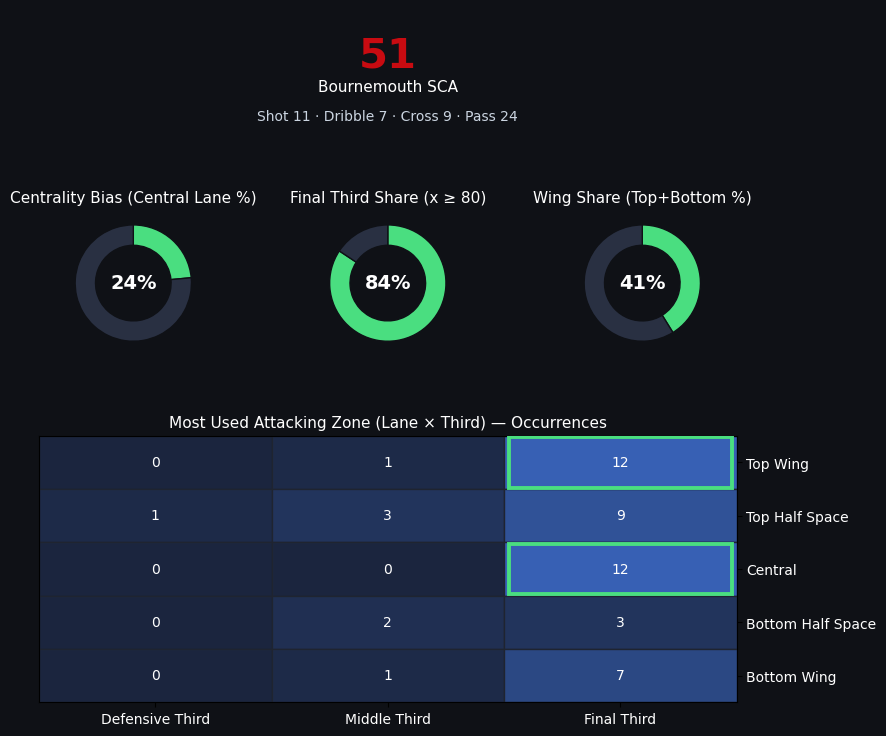

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.lines import Line2D
from mplsoccer import Pitch

FILE = "8-23-2025.xlsx"
SHEET = "Sheet1"

FIG_BG = "#0f1116"
AX_BG  = "#151823"
LINES  = "white"

LANE_NAMES  = ["Top Wing", "Top Half Space", "Central", "Bottom Half Space", "Bottom Wing"]
LANE_EDGES  = np.linspace(0, 80, 6)
THIRD_NAMES = ["Defensive Third", "Middle Third", "Final Third"]
THIRD_EDGES = [0, 40, 80, 120]

event_order = ["Pass", "Dribble", "Cross", "Shot"]
event_colors = {
    "Shot":    "#ff4c4c",
    "Dribble": "#00ff99",
    "Cross":   "#bb86fc",
    "Pass":    "#ff66cc",
}

df = pd.read_excel(FILE, sheet_name=SHEET)

normalize = {
    "shot": "Shot", "shots": "Shot",
    "dribble": "Dribble", "dribbles": "Dribble",
    "cross": "Cross", "crosses": "Cross",
    "pass": "Pass", "passes": "Pass",
}
df["Event"] = (
    df["Event"].astype(str).str.strip().str.lower().map(normalize).fillna(df["Event"])
)

df["X_sb"] = (df["X"].astype(float) * 1.2).clip(0, 120)
df["Y_sb"] = (df["Y"].astype(float) * 0.8).clip(0, 80)

wolves_df = df[df["Team"].astype(str).str.strip().str.lower() == "wolves"].copy()
opp_df    = df[df["Team"].astype(str).str.strip().str.lower() != "wolves"].copy()
opp_name  = opp_df["Team"].mode().iat[0] if not opp_df.empty else "Opponent"

def lane_from_y(y):
    return int(np.clip(np.digitize(y, LANE_EDGES, right=False) - 1, 0, 4))

def third_from_x(x):
    return int(np.clip(np.digitize(x, THIRD_EDGES, right=False) - 1, 0, 2))

def add_lane_label(ax, lane_idx, color="white"):
    y0, y1 = LANE_EDGES[lane_idx], LANE_EDGES[lane_idx+1]
    yc = (y0 + y1) / 2
    ax.text(-3, yc, LANE_NAMES[lane_idx], va="center", ha="right", color=color, fontsize=10)

def count_by_lane(df_in):
    if df_in.empty:
        return pd.Series(0, index=LANE_NAMES)
    lanes = df_in["Y_sb"].apply(lane_from_y)
    return (
        pd.Series(lanes)
        .value_counts()
        .reindex(range(5), fill_value=0)
        .rename(index=dict(enumerate(LANE_NAMES)))
        .astype(int)
    )

def count_by_lane_event(df_in):
    """Return DataFrame indexed by lanes with columns=event_order (int counts)."""
    out = pd.DataFrame(0, index=LANE_NAMES, columns=event_order, dtype=int)
    if df_in.empty:
        return out
    lanes = df_in["Y_sb"].apply(lane_from_y)
    tmp = pd.DataFrame({"lane": lanes, "event": df_in["Event"]})
    grp = tmp.groupby(["lane", "event"]).size()
    for (li, ev), c in grp.items():
        if ev in event_order:
            out.iloc[li, out.columns.get_loc(ev)] = int(c)
    return out

def count_events(df_in):
    """Series of counts by event (event_order)."""
    s = pd.Series(0, index=event_order, dtype=int)
    if df_in.empty:
        return s
    g = df_in["Event"].value_counts()
    for ev in event_order:
        if ev in g.index:
            s[ev] = int(g[ev])
    return s

def draw_lane_bars_on_pitch(
    ax, lane_event_counts, team_outline="#8b93a1",
    x0=1.5, max_bar_width=24.0, vpad=2.0, lw=0.9, alpha=0.22
):
    """Embedded horizontal stacked bars inside each vertical lane band on the pitch."""
    totals = lane_event_counts.sum(axis=1)
    max_total = max(int(totals.max()), 1)

    for i, lane in enumerate(LANE_NAMES):
        y0, y1 = LANE_EDGES[i], LANE_EDGES[i+1]
        height = max((y1 - y0) - 2*vpad, 0.5)
        lane_total = int(totals.loc[lane])
        total_w = (lane_total / max_total) * max_bar_width if max_total else 0.0

        x_left = x0
        for ev in event_order:
            val = int(lane_event_counts.loc[lane, ev])
            seg_w = (val / max_total) * max_bar_width if max_total else 0.0
            if seg_w > 0:
                ax.add_patch(Rectangle(
                    (x_left, y0 + vpad), seg_w, height,
                    facecolor=event_colors[ev], edgecolor="none",
                    linewidth=0.0, alpha=alpha, zorder=1
                ))
                x_left += seg_w

        if total_w > 0 and lw > 0:
            ax.add_patch(Rectangle(
                (x0, y0 + vpad), total_w, height,
                fill=False, edgecolor=team_outline, linewidth=lw, zorder=2
            ))

def plot_lanes_with_points(team_name, team_df, team_color="#f7a400",
                           point_size=26, draw_embedded_bars=True):
    pitch = Pitch(pitch_type="statsbomb", pitch_color=AX_BG, line_color=LINES)
    fig, ax = pitch.draw(figsize=(10, 7))
    fig.set_facecolor(FIG_BG)

    for i in range(5):
        y0, y1 = LANE_EDGES[i], LANE_EDGES[i+1]
        alpha_band = 0.10 if i % 2 == 0 else 0.16
        ax.add_patch(Rectangle((0, y0), 120, y1 - y0,
                               fc="white", ec=None, alpha=alpha_band, zorder=0))
        add_lane_label(ax, i, color="white")

    if not team_df.empty:
        for ev in event_order:
            sub = team_df[team_df["Event"] == ev]
            if not sub.empty:
                pitch.scatter(
                    sub["X_sb"], sub["Y_sb"],
                    ax=ax, s=point_size, c=event_colors[ev],
                    edgecolors="black", linewidths=0.6, zorder=3, label=ev
                )

    lane_counts       = count_by_lane(team_df)
    lane_event_counts = count_by_lane_event(team_df)

    if draw_embedded_bars:
        draw_lane_bars_on_pitch(
            ax, lane_event_counts,
            team_outline="#8b93a1",
            x0=1.5, max_bar_width=24.0, vpad=2.0, lw=0.9, alpha=0.22
        )

    total = int(len(team_df))
    lines = [f"{ln}: {int(c)} ({(c/total*100 if total else 0):.1f}%)" for ln, c in lane_counts.items()]
    ax.text(123, 40, "\n".join(lines), va="center", ha="left", color="white", fontsize=10)

    handles = [Line2D([0], [0], marker='o', linestyle='',
                      markerfacecolor=event_colors[ev], markeredgecolor='black',
                      markersize=8, label=ev) for ev in event_order]
    leg = ax.legend(handles=handles, title="Event",
                    bbox_to_anchor=(1.22, 1.0), loc="upper left",
                    frameon=True, facecolor=AX_BG, edgecolor="white", labelcolor="white")
    for t in leg.get_texts():
        t.set_color("white")
    leg.get_title().set_color("white")

    ax.set_title(f"{team_name}: Shot Creating Actions by Vertical Lanes (Attacking →)",
                 color="white", fontsize=15, pad=10)
    plt.show()
    return lane_counts, lane_event_counts

def compute_shared_lane_max(*lane_event_dfs, events=None):
    """
    Returns the maximum stacked SCA count across lanes, over all provided DataFrames.
    Each DF is indexed by LANE_NAMES with columns of event types.
    """
    if events is None:
        events = event_order
    max_val = 0
    for df_in in lane_event_dfs:
        if df_in is None or len(df_in) == 0:
            continue
        cols = [c for c in events if c in df_in.columns]
        if not cols:
            continue
        stacked = df_in[cols].sum(axis=1)
        if not stacked.empty:
            max_val = max(max_val, int(stacked.max()))
    return max_val

def plot_lane_bars_single_stacked(counts_ev, label, outline_color, ymax=None, headroom=0.12):
    """
    Stacked bar chart of SCA by vertical lanes.
    - ymax: if provided, sets a shared y-limit across charts
    - headroom: fraction of ymax to leave as padding above tallest bar
    """
    idx = LANE_NAMES
    cdf = counts_ev.reindex(idx).fillna(0)
    for ev in event_order:
        if ev not in cdf.columns:
            cdf[ev] = 0
    cdf = cdf[event_order].astype(int)

    x = np.arange(len(idx))
    width = 0.55

    fig, ax = plt.subplots(figsize=(8.8, 4.4), facecolor=FIG_BG)
    ax.set_facecolor(AX_BG)

    bottoms = np.zeros(len(idx), dtype=int)
    for ev in event_order:
        ax.bar(
            x, cdf[ev].values, width, bottom=bottoms,
            color=event_colors[ev], edgecolor=outline_color, linewidth=2.0
        )
        bottoms += cdf[ev].values

    local_max = int(bottoms.max()) if len(bottoms) else 0
    y_max = ymax if (ymax is not None) else local_max
    y_max = max(y_max, 1) 
    ax.set_ylim(0, y_max * (1 + headroom))

    ax.set_xticks(x)
    ax.set_xticklabels(idx, rotation=0, ha="center", color="white")
    ax.set_ylabel("SCA count", color="white")
    ax.tick_params(axis="y", colors="white")
    for s in ax.spines.values():
        s.set_color("white")

    ev_handles = [Patch(facecolor=event_colors[ev], edgecolor="none", label=ev) for ev in event_order]
    leg = ax.legend(
        handles=ev_handles, loc="upper left", frameon=True,
        facecolor=AX_BG, edgecolor="white", title="Event", labelcolor="white"
    )
    for t in leg.get_texts():
        t.set_color("white")
    leg.get_title().set_color("white")

    ax.set_title(f"{label}: Shot Creating Actions by Vertical Lanes (Stacked)",
                 color="white", pad=8)
    plt.tight_layout()
    plt.show()

def summary_components(team_df):
    total = int(len(team_df))
    if total == 0:
        return {
            "total": 0,
            "central_share": 0.0,
            "final_third_share": 0.0,
            "wings_share": 0.0,
            "grid_counts": np.zeros((5, 3), dtype=int),
            "most_used": (2, 2),                
            "most_used_cells": [(2, 2)],        
            "event_counts": pd.Series(0, index=event_order, dtype=int)
        }

    lanes  = team_df["Y_sb"].apply(lane_from_y).to_numpy()
    thirds = team_df["X_sb"].apply(third_from_x).to_numpy()
    central_share     = (lanes == 2).mean()
    final_third_share = (team_df["X_sb"] >= 80).mean()
    wings_share       = np.isin(lanes, [0, 4]).mean()

    grid = np.zeros((5, 3), dtype=int)
    for l, t in zip(lanes, thirds):
        grid[l, t] += 1

    max_val = grid.max() if grid.size else 0
    ties = np.argwhere(grid == max_val) if max_val > 0 else np.array([[2, 2]])
    ties_list = [(int(i), int(j)) for i, j in ties]
    l_idx, t_idx = ties_list[0] 

    return {
        "total": total,
        "central_share": float(central_share),
        "final_third_share": float(final_third_share),
        "wings_share": float(wings_share),
        "grid_counts": grid,
        "most_used": (l_idx, t_idx),       
        "most_used_cells": ties_list,      
        "event_counts": count_events(team_df)
    }


def donut(ax, share, title, label_inside=True):
    ax.set_facecolor(AX_BG)
    ax.pie(
        [share, 1 - share],
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.35, edgecolor=FIG_BG),
        colors=["#4ade80", "#293042"],
    )
    if label_inside:
        ax.text(0, 0, f"{share*100:.0f}%", ha="center", va="center",
                color="white", fontsize=14, fontweight="bold")
    ax.set_title(title, color="white", fontsize=11, pad=6)

def big_metric(ax, value, title, color="#e5e7eb", breakdown=None):
    ax.set_facecolor(AX_BG)
    ax.axis("off")
    ax.text(0.5, 0.62, str(value), ha="center", va="center",
            color=color, fontsize=30, fontweight="bold")
    ax.text(0.5, 0.36, title, ha="center", va="center",
            color="white", fontsize=11)
    if breakdown is not None and len(breakdown) > 0:
        parts = [f"{ev} {int(breakdown.get(ev, 0))}" for ev in ["Shot","Dribble","Cross","Pass"]]
        ax.text(0.5, 0.12, " · ".join(parts), ha="center", va="center",
                color="#cbd5e1", fontsize=10)

def heatmap_zone(ax, grid_counts, highlights, title, y_labels_side="left",
                 highlight_inset=0.03, cell_width=1.4, cell_height=1.2):
    """
    Draws the (lane x third) heatmap and outlines one or multiple 'highlights'.
    `highlights` can be a tuple (li, tj) OR a list of tuples [(li, tj), ...].
    """
    ax.set_facecolor(AX_BG); ax.set_title(title, color="white", fontsize=11, pad=6)
    n_rows, n_cols = grid_counts.shape
    total_width = n_cols * cell_width; total_height = n_rows * cell_height
    ax.set_xticks([c * cell_width for c in range(n_cols)])
    ax.set_xticklabels(THIRD_NAMES, color="white")
    ax.set_yticks([r * cell_height for r in range(n_rows)])
    ax.set_yticklabels(LANE_NAMES, color="white")

    if y_labels_side == "right":
        ax.yaxis.tick_right(); ax.yaxis.set_label_position("right")
        ax.tick_params(axis='y', labelleft=False, labelright=True)
    else:
        ax.yaxis.tick_left(); ax.yaxis.set_label_position("left")
        ax.tick_params(axis='y', labelright=False, labelleft=True)

    vmax = max(grid_counts.max(), 1)
    for i in range(n_rows):
        for j in range(n_cols):
            val = grid_counts[i, j]
            shade = 0.15 + 0.65 * (val / vmax)
            ax.add_patch(Rectangle(
                (j*cell_width - cell_width/2, i*cell_height - cell_height/2),
                cell_width, cell_height,
                facecolor=(0.25, 0.45, 0.85, shade),
                edgecolor="#1f2430", linewidth=1.0, zorder=1
            ))
            ax.text(j*cell_width, i*cell_height, str(val),
                    ha="center", va="center", color="white", fontsize=10, zorder=2)

    if isinstance(highlights, tuple):
        highlights = [highlights]
    highlights = list(highlights) if highlights else []

    for (li, tj) in highlights:
        x0 = (tj*cell_width - cell_width/2) + highlight_inset
        y0 = (li*cell_height - cell_height/2) + highlight_inset
        ax.add_patch(Rectangle(
            (x0, y0), cell_width-2*highlight_inset, cell_height-2*highlight_inset,
            fill=False, edgecolor="#4ade80", linewidth=2.8, zorder=10, snap=True
        ))

    ax.set_xlim(-cell_width/2, total_width - cell_width/2)
    ax.set_ylim(total_height - cell_height/2, -cell_height/2)
    ax.grid(False)


def plot_summary_dashboard_single(s_sum, label, color):
    fig = plt.figure(figsize=(9, 9), facecolor=FIG_BG)
    gs = fig.add_gridspec(3, 1, height_ratios=[1.0, 1.2, 2.2], hspace=0.45)

    ax_total = fig.add_subplot(gs[0, 0])
    big_metric(ax_total, s_sum["total"], f"{label} SCA", color=color, breakdown=s_sum["event_counts"])

    sub = gs[1, 0].subgridspec(1, 3, wspace=0.35)
    donut(fig.add_subplot(sub[0, 0]), s_sum["central_share"], "Centrality Bias (Central Lane %)")
    donut(fig.add_subplot(sub[0, 1]), s_sum["final_third_share"], "Final Third Share (x ≥ 80)")
    donut(fig.add_subplot(sub[0, 2]), s_sum["wings_share"], "Wing Share (Top+Bottom %)")

    ax_heat = fig.add_subplot(gs[2, 0])
    heatmap_zone(
        ax_heat, s_sum["grid_counts"], s_sum.get("most_used_cells", s_sum["most_used"]),
        "Most Used Attacking Zone (Lane × Third) — Occurrences",
        y_labels_side="right"
    )
    plt.show()


(wolves_lane_counts, wolves_lane_event) = plot_lanes_with_points(
    "Wolves", wolves_df, team_color="#f7a400", draw_embedded_bars=True
)
(opp_lane_counts, opp_lane_event) = plot_lanes_with_points(
    opp_name, opp_df, team_color="#c80b11", draw_embedded_bars=True
)

shared_max = compute_shared_lane_max(wolves_lane_event, opp_lane_event, events=event_order)

plot_lane_bars_single_stacked(
    wolves_lane_event, "Wolves", outline_color="#f7a400",
    ymax=shared_max, headroom=0.12 
)
plot_lane_bars_single_stacked(
    opp_lane_event, opp_name, outline_color="#c80b11",
    ymax=shared_max, headroom=0.12
)

wolves_sum = summary_components(wolves_df)
opp_sum    = summary_components(opp_df)
plot_summary_dashboard_single(wolves_sum, "Wolves", "#f7a400")
plot_summary_dashboard_single(opp_sum, opp_name, "#c80b11")
